# STM32 Cube AI and TensorFlow, Activity Recognition with Multi-Layer Perceptron (MLP)

### Objectives

- Train the first model with TensorFlow and deploy the inference on a microcontroller using STM32 Cube AI
- Develop the activity recognition application using multi-layer perceptron (MLP)
- Evaluate with and without feature extraction. Run and evaluate the performance on a STM32 microcontroller

## Preparation

Import Libraries

In [1]:
import serial.tools.list_ports
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, random

base_dir = os.getcwd()
samples_dir = os.path.join(base_dir, 'Samples')

### Connect the MCU to the host PC

It displays a list of available COM ports. It prompts the user to enter the COM port number to which the MCU is connected. Then, it initializes the serial communication object at a speed of 115200 baud.

In [2]:
print('Com ports list:')
comPorts = list(serial.tools.list_ports.comports())
for comPort in comPorts:
    print(comPort)
chooseComPort = input('Please insert port number: ')
ser = serial.Serial('COM{}'.format(chooseComPort), 115200)

Com ports list:
COM6 - Serie estándar sobre el vínculo Bluetooth (COM6)
COM7 - Serie estándar sobre el vínculo Bluetooth (COM7)
COM8 - Serie estándar sobre el vínculo Bluetooth (COM8)
COM9 - Serie estándar sobre el vínculo Bluetooth (COM9)
COM5 - Dispositivo serie USB (COM5)


Please insert port number:  5


Please insert port number:  5


### Helper functions for data acquisition

`convert_to_list`: takes a string of comma-separated values ​​and converts it into a list of floats.

`convert_list_to_df`: takes the list of interleaved floats X, Y, Z and arranges them into a Pandas DataFrame with columns X, Y, Z.

In [3]:
def convert_to_list(value):
    vals = value.split(",")
    del vals[-1]
    results = list(map(float, vals))
    return results

def convert_list_to_df(lst):
    x = lst[0::3]
    y = lst[1::3]
    z = lst[2::3]
    df = pd.DataFrame({'X': x, 'Y': y, 'Z': z})
    return df

## Data Acquisition
Input the letter of the sample you want to acquire. The MCU will send the XYZ Accelerometer data as a timeseries of length 30. 

Run the cell -> Press a button on the MCU and move it until a LED turns off -> Insert the number 1 into the prompt to acquire the data or number 2 to exit -> Repeat

It reads the serial port data, cleans it and converts it to a DataFrame, concatenates it to the total data set for that letter, and saves it to a CSV file.

In [5]:
letter = input('Please insert letter to collect data: ')
stride = 30
f = os.path.join(samples_dir, 'letter_{}_stride_{}.csv'.format(letter, stride))
if os.path.exists(f):
    print('File exists and data will be appended...')
    xyz_df = pd.read_csv(f)
else:
    print('New sample, starting blank...')
    xyz_df = pd.DataFrame(columns=['X', 'Y', 'Z'])

while input('1 - acquire sample, 2 - exit: ') == '1':
    line = ser.readline()
    print("Serial: ", line)
    lineList = convert_to_list(line.decode('utf-8'))    
    new_df = convert_list_to_df(lineList)
    print('\nNew data acquired:\n', new_df.describe())
   
    # Si es el primer lote de datos, inicializa el DataFrame.
    if xyz_df.empty:
        xyz_df = new_df
    # Si no, concaténalo con los datos existentes.
    else:
        xyz_df = pd.concat([xyz_df, new_df], ignore_index=True)
    print('Total Data count:', int(xyz_df.shape[0]/stride))    

print('Saving data to:', f)
print('Total data of sample {}:\n'.format(letter), xyz_df.describe())
xyz_df.to_csv(f, index=False)

Please insert letter to collect data:  0M


File exists and data will be appended...


1 - acquire sample, 2 - exit:  2


Saving data to: C:\Users\Melissa\OneDrive - Universidad Autónoma de Aguascalientes\9no Semestre\IA con MCU\Jupiter Python\Samples\letter_0M_stride_30.csv
Total data of sample 0M:
                  X            Y            Z
count  2700.000000  2700.000000  2700.000000
mean     -0.094833     0.023673     0.971968
std       0.206228     0.074325     0.102111
min      -0.985352    -0.290527     0.000000
25%      -0.187073    -0.014893     0.937927
50%      -0.069336     0.014893     0.972168
75%       0.039734     0.053711     1.007873
max       0.574951     0.694580     1.874756


## Load data
Load all samples raw. Note that a single Accelerometer data batch will only contain 30 time steps. Thus to acquire single batches we must use an according "stride" of 30.

It loads the data from each csv file and segments it with windows of 30, creating the list of input data (data) and its numeric class labels (labels).

In [4]:
data_files = [file for file in os.listdir(samples_dir) if '.csv' in file]

stride = 30
data = []
labels = []
for idx, file in enumerate(data_files):
    df = pd.read_csv(os.path.join(samples_dir, file))
    x = df['X'].to_numpy()
    y = df['Y'].to_numpy()
    z = df['Z'].to_numpy()
    
    for i in range(int(df.shape[0]/stride)):
        base_idx = i * stride
        batch = np.array([x[base_idx:base_idx+stride], y[base_idx:base_idx+stride], z[base_idx:base_idx+stride]])
        batch = batch.reshape((3, stride))
        data.append(batch)
        labels.append(idx)
        
    print('Added {} data to the data list with label: {}'.format(file, idx))

Added letter_0m_stride_30.csv data to the data list with label: 0
Added letter_1H_stride_30.csv data to the data list with label: 1
Added letter_2R_stride_30.csv data to the data list with label: 2



Prints the shape (dimensions) of data arrays and labels

In [5]:
print(np.array(data).shape)
print(np.array(labels).shape)
print(labels)

(270, 3, 30)
(270,)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


### Plot one data sample.

Graph a single sample from the dataset, showing the X, Y, and Z axis values ​​across the 30 sampled data points.

<Figure size 640x480 with 0 Axes>

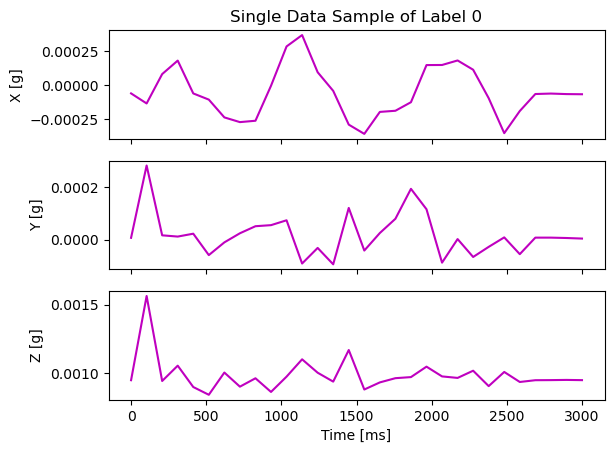

In [ ]:
def plot_single_sample(data_sample, label='Not Specified'):
    plt.clf()
    fig, axs = plt.subplots(3)
    t = np.linspace(0, data_sample.shape[1] * 100, data_sample.shape[1]) # Acelerómetro muestreado a 100ms
    axs[0].set_title(label='Single Data Sample of Label {}'.format(label))
    axs[0].plot(t, data_sample[0], c='m') # Sin /scaling
    axs[0].set_ylabel('X [g]')
    plt.setp(axs[0].get_xticklabels(), visible=False)
    axs[1].plot(t, data_sample[1], c='m') # Sin /scaling
    axs[1].set_ylabel('Y [g]')
    plt.setp(axs[1].get_xticklabels(), visible=False)
    axs[2].plot(t, data_sample[2], c='m') # Sin /scaling
    axs[2].set_ylabel('Z [g]')
    plt.xlabel('Time [ms]')
    plt.show()
    
idx = random.randint(0, len(data)-1)
plot_single_sample(data_sample=data[idx], label=labels[idx])

## RAW MODEL 

### Training

It takes the input data and shuffles it randomly. It converts the numeric class labels into one-hot-encoding binary vectors.

It creates a sequential Keras model and defines its architecture. It's a 4-layer model. The input layer receives the d3(3,30) matrix and flattens it into a vector of 90, thus having 90 neurons. The first hidden layer has 30 neurons and the second hidden layer has 20 neurons, both with relu activation. 50% of the neurons are randomly deactivated during training to avoid overfitting. Finally, the output layer has 3 neurons, one for each class. This layer converts the neuron outputs into a probability distribution.

In [6]:
x_train, y_train = sklearn.utils.shuffle(np.array(data), np.array(labels))
y_train = tf.keras.utils.to_categorical(y_train, 3)  # One-Hot-Encoding

model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(3, stride)),   # define la forma (shape) de los datos de entrada
            tf.keras.layers.Flatten(),           # aplana en un vector
            tf.keras.layers.Dense(30, activation="relu"), # capa oculta con 30 neuronas
            tf.keras.layers.Dropout(0.5),         # desactiva" aleatoriamente 50% de neuronas
            tf.keras.layers.Dense(20, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(3, activation="softmax") # Capa de salida
        ]
    )

model.summary()  # Resumen del modelo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,413 (13.33 KB)

 Trainable params: 3,413 (13.33 KB)

 Non-trainable params: 0 (0.00 B)

Run the model training (model.fit) using the training data for 200 epochs. The model is compiled with the Adam optimizer and the Categorical Crossentropy loss function. 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=1, epochs=200, validation_split=0.4)

Epoch 1/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3457 - loss: 1.1903 - val_accuracy: 0.5556 - val_loss: 1.0446
Epoch 2/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4198 - loss: 1.0903 - val_accuracy: 0.6389 - val_loss: 1.0220
Epoch 3/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4136 - loss: 1.0677 - val_accuracy: 0.7870 - val_loss: 1.0011
Epoch 4/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4136 - loss: 1.0377 - val_accuracy: 0.7593 - val_loss: 0.9647
Epoch 5/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5556 - loss: 0.9694 - val_accuracy: 0.7037 - val_loss: 0.8951
Epoch 6/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4383 - loss: 1.0005 - val_accuracy: 0.7407 - val_loss: 0.8646
Epoch 7/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5679 - loss: 0.9408 - val_accuracy: 0.7963 - val_loss: 0.7906
Epoch 8/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5617 - loss: 0.8909 - val_accu

Create a graph that compares the model's accuracy on training data vs. validation data over time.

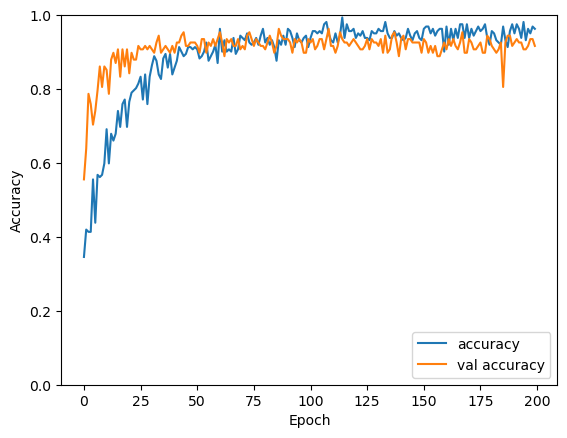

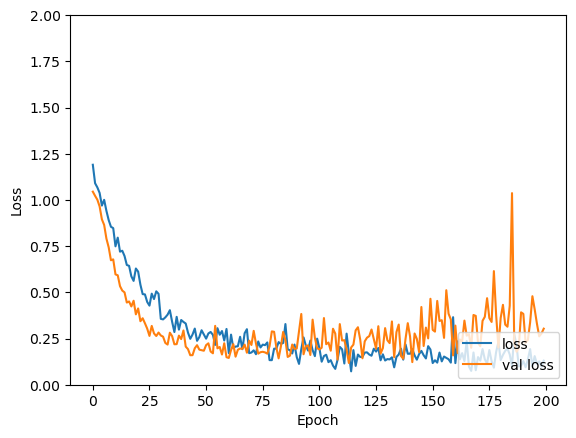

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

The model is exported to an .h5 file

In [ ]:
model.save('raw_model.h5')

### Model inference
Here we perform a single inference of the model. 

Run the cell -> Draw one of your letter classes with the MCU again (try to keep the movements similar as before) -> Press enter to acquire the MCU data -> view the model prediction. 

In [17]:
input('Press Enter once MCU is ready')
line = ser.readline()
lineList = convert_to_list(line.decode('utf-8'))
new_df = convert_list_to_df(lineList)
#print('New data acquired:\n', new_df.describe())

x = new_df['X'].to_numpy()
y = new_df['Y'].to_numpy()
z = new_df['Z'].to_numpy()

inf_data = np.array([x, y, z])
#plot_single_sample(data_sample=inf_data.reshape((3, stride)))
#For inference we have to explicitly tell the model that the data has a batchsize of 1
inf_data = inf_data.reshape((1, 3, stride))

pred = model.predict(inf_data)
print('Model Prediction: ', np.argmax(pred))

Press Enter once MCU is ready 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Model Prediction:  2


New data acquired:
                X          Y          Z
count  30.000000  30.000000  30.000000
mean    0.017033   0.041805   0.979932
std     0.182636   0.236775   0.122536
min    -0.282471  -0.495605   0.751221
25%    -0.125488  -0.014404   0.917237
50%    -0.001221   0.023682   0.993286
75%     0.116089   0.202881   1.038818
max     0.458984   0.662109   1.196777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Model Prediction:  2


## MODEL WITH FEATURE EXTRACTION

### Feature extraction

Instead of directly using the raw data to train a network, _condense_ the contained information into fewer data points. This not only leads to less memory required for the features, but also to potentially smaller networks and better performance. Finding good features can be very hard, but for many applications you can read papers about which features perform well and how to calculate them.

In this task a sliding window of size 6 is used to calculate the piece wise mean and variance of the accelerator data.


In [18]:
data_files = [file for file in os.listdir(samples_dir) if '.csv' in file]

stride = 30
slidingWindowExt = 6
feature_data = []
feature_labels = []
for idx, file in enumerate(data_files):
    df = pd.read_csv(os.path.join(samples_dir, file))
    x = df['X'].to_numpy()
    y = df['Y'].to_numpy()
    z = df['Z'].to_numpy()
    
    for i in range(int(df.shape[0]/stride)):
        base_idx = i * stride

        # Mean feature
        x_mean_ext = np.array([np.mean(x[i:i + slidingWindowExt]) for i in range(base_idx, base_idx + stride, slidingWindowExt)])
        y_mean_ext = np.array([np.mean(y[i:i + slidingWindowExt]) for i in range(base_idx, base_idx + stride, slidingWindowExt)])
        z_mean_ext = np.array([np.mean(z[i:i + slidingWindowExt]) for i in range(base_idx, base_idx + stride, slidingWindowExt)])
        # STD feature
        x_std_ext = np.array([np.std(x[i:i + slidingWindowExt]) for i in range(base_idx, base_idx + stride, slidingWindowExt)])
        y_std_ext = np.array([np.std(y[i:i + slidingWindowExt]) for i in range(base_idx, base_idx + stride, slidingWindowExt)])
        z_std_ext = np.array([np.std(z[i:i + slidingWindowExt]) for i in range(base_idx, base_idx + stride, slidingWindowExt)])
        
        batch = np.array([x_mean_ext, y_mean_ext, z_mean_ext, x_std_ext, y_std_ext, z_std_ext])
        feature_data.append(batch)
        feature_labels.append(idx)
        
    print('Added {} data to the feature data list with label: {}'.format(file, idx))

print(feature_data[0].shape)
#print(feature_data)

Added letter_0m_stride_30.csv data to the feature data list with label: 0
Added letter_1H_stride_30.csv data to the feature data list with label: 1
Added letter_2R_stride_30.csv data to the feature data list with label: 2
(6, 5)


### Plot single feature sample

Graph a single sample from the dataset, showing the X, Y, and Z axis values ​​across the features extracted

<Figure size 640x480 with 0 Axes>

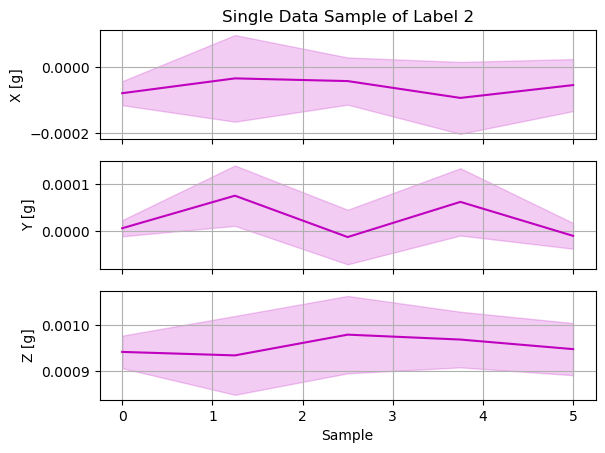

In [19]:
def plot_single_feature_sample(data_sample, label='Not Specified'):
    plt.clf()
    fig, axs = plt.subplots(3)
    t = np.linspace(0, data_sample.shape[1], data_sample.shape[1])
    scaling = 2**10 #The STM ADC is 10bit so scale to get [g]
    axs[0].set_title(label='Single Data Sample of Label {}'.format(feature_labels[idx]))
    
    xf_means = data_sample[0] / scaling
    yf_means = data_sample[1] / scaling
    zf_means = data_sample[2] / scaling
    
    xf_stds = data_sample[3] / scaling
    yf_stds = data_sample[4] / scaling
    zf_stds = data_sample[5] / scaling
    
    axs[0].grid()
    axs[0].plot(t, xf_means, c='m')
    axs[0].fill_between(t, xf_means - xf_stds, xf_means + xf_stds, alpha=0.2, color='m')
    axs[0].set_ylabel('X [g]')
    plt.setp(axs[0].get_xticklabels(), visible=False)
    axs[1].grid()
    axs[1].plot(t, yf_means, c='m')
    axs[1].fill_between(t, yf_means - yf_stds, yf_means + yf_stds, alpha=0.2, color='m')
    axs[1].set_ylabel('Y [g]')
    plt.setp(axs[1].get_xticklabels(), visible=False)
    axs[2].grid()
    axs[2].plot(t, zf_means, c='m')
    axs[2].fill_between(t, zf_means - zf_stds, zf_means + zf_stds, alpha=0.2, color='m')
    axs[2].set_ylabel('Z [g]')
    
    plt.xlabel('Sample')
    plt.show()
    
idx = random.randint(0, len(feature_data)-1)
plot_single_feature_sample(data_sample=feature_data[idx], label=feature_labels[idx])

### Feature-based model Trainig
The neural network basically uses the same architecture as before. Simply the input shape has changed. 

The code takes the input data and shuffles it randomly. It converts the numeric class labels into one-hot-encoding binary vectors.

It creates a sequential Keras model and defines its architecture. It's a 4-layer model. The input layer receives the d3(6,5) matrix and flattens it into a vector of 30, thus having 30 neurons. The first hidden layer has 30 neurons and the second hidden layer has 20 neurons, both with relu activation. 50% of the neurons are randomly deactivated during training to avoid overfitting. Finally, the output layer has 3 neurons, one for each class. This layer converts the neuron outputs into a probability distribution.

In [78]:
x_train, y_train = sklearn.utils.shuffle(np.array(feature_data), np.array(feature_labels))
y_train = tf.keras.utils.to_categorical(y_train, 3)

data_shape = x_train[0].shape
print(data_shape)
model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=data_shape),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(data_shape[0] * data_shape[1], activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(20, activation="relu"),
            tf.keras.layers.Dense(3, activation="softmax")
        ]
    )

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

(6, 5)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,613 (6.30 KB)

 Trainable params: 1,613 (6.30 KB)

 Non-trainable params: 0 (0.00 B)

Train the model for 300 epochs

In [79]:
history = model.fit(x_train, y_train, batch_size=32, epochs=300, validation_split=0.4)

Epoch 1/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2963 - loss: 1.2973 - val_accuracy: 0.3704 - val_loss: 1.1638
Epoch 2/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3333 - loss: 1.1812 - val_accuracy: 0.3704 - val_loss: 1.1200
Epoch 3/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3395 - loss: 1.1603 - val_accuracy: 0.3704 - val_loss: 1.1038
Epoch 4/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2840 - loss: 1.1605 - val_accuracy: 0.3333 - val_loss: 1.0966
Epoch 5/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3025 - loss: 1.1181 - val_accuracy: 0.3056 - val_loss: 1.0950
Epoch 6/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3272 - loss: 1.1221 - val_accuracy: 0.3056 - val_loss: 1.0978
Epoch 7/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3519 - loss: 1.1041 - val_accuracy: 0.3056 - val_loss: 1.0973
Epoch 8/300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3704 - loss: 1.1014 - val_accuracy: 0.3056 - val_loss:

Create a graph that compares the model's accuracy on training data vs. validation data over time.

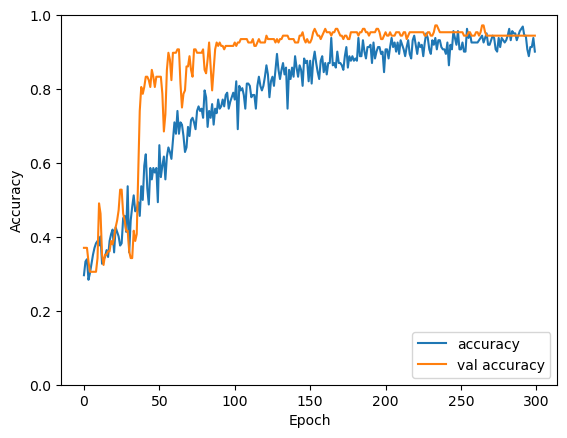

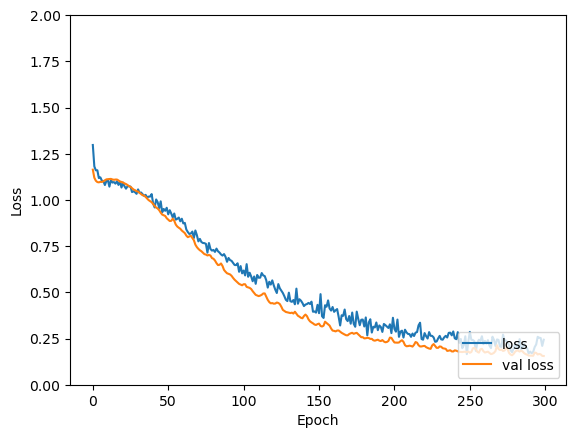

In [80]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')

### Feature-based model inference
Here we perform a single inference of the model, but with the feature based model 

Run the cell -> Draw one of your letter classes with the MCU again (try to keep the movements similar as before) -> Press enter to acquire the MCU data -> view the model prediction. How does it perform now?

In [61]:
input('Press Enter once MCU is ready')
line = ser.readline()
lineList = convert_to_list(line.decode('utf-8'))
new_df = convert_list_to_df(lineList)
#print('New data acquired:\n', new_df.describe())

x = new_df['X'].to_numpy()
y = new_df['Y'].to_numpy()
z = new_df['Z'].to_numpy()
stride = 30
slidingWindowExt = 6
1
# Mean feature
x_mean_ext = np.array([np.mean(x[i:i + slidingWindowExt]) for i in range(0, stride, slidingWindowExt)])
y_mean_ext = np.array([np.mean(y[i:i + slidingWindowExt]) for i in range(0, stride, slidingWindowExt)])
z_mean_ext = np.array([np.mean(z[i:i + slidingWindowExt]) for i in range(0, stride, slidingWindowExt)])
# STD feature
x_std_ext = np.array([np.std(x[i:i + slidingWindowExt]) for i in range(0, stride, slidingWindowExt)])
y_std_ext = np.array([np.std(y[i:i + slidingWindowExt]) for i in range(0, stride, slidingWindowExt)])
z_std_ext = np.array([np.std(z[i:i + slidingWindowExt]) for i in range(0, stride, slidingWindowExt)])

inf_data = np.array([x_mean_ext, y_mean_ext, z_mean_ext, x_std_ext, y_std_ext, z_std_ext])

#For inference we have to explicitly tell the model that the data has a batchsize of 1
#plot_single_feature_sample(data_sample=inf_data)
inf_data = inf_data.reshape((1, data_shape[0], data_shape[1]))
print(inf_data.shape)

pred = model.predict(inf_data)
print('Model Prediction: ', np.argmax(pred))

Press Enter once MCU is ready 


(1, 6, 5)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model Prediction:  2


New data acquired:
                X          Y          Z
count  30.000000  30.000000  30.000000
mean   -0.005062   0.038818   0.979948
std     0.006966   0.003944   0.005639
min    -0.039307   0.023193   0.964600
25%    -0.005798   0.037415   0.979431
50%    -0.003906   0.039307   0.980835
75%    -0.001526   0.040710   0.983276
max    -0.000244   0.045166   0.988281
[[-0.00866717 -0.00402817 -0.00317383 -0.00451633 -0.0049235 ]
 [ 0.03609183  0.04069017  0.03881833  0.03971333  0.03877783]
 [ 0.97745767  0.980306    0.98042817  0.9798585   0.98168967]
 [ 0.01381706  0.00233214  0.0021375   0.00182006  0.00351374]
 [ 0.00670013  0.00208915  0.00167351  0.00282502  0.00184549]
 [ 0.00776991  0.0025161   0.0035164   0.00719659  0.0036402 ]]
(6, 5)
************************
[[[-0.00866717 -0.00402817 -0.00317383 -0.00451633 -0.0049235 ]
  [ 0.03609183  0.04069017  0.03881833  0.03971333  0.03877783]
  [ 0.97745767  0.980306    0.98042817  0.9798585   0.98168967]
  [ 0.01381706  0.00233214

## Evaluating Inferences

Displays the confusion matrix and various evaluation metrics for a set of new inferences

Accuracy:  0.9333333333333333
Recall:  [0.9 1.  0.9]
Precision:  [1.         0.83333333 1.        ]
F1 Score:  [0.94736842 0.90909091 0.94736842]


NameError: name 'plt' is not defined

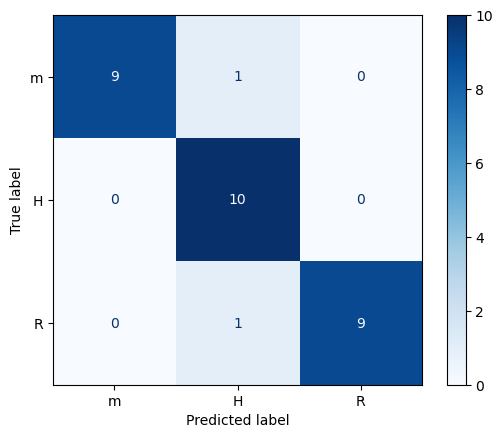

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score

# Predicción
# 30-30-20-3
# batch_size=32, epochs=300, validation_split=0.4
''' #CRUDOS
yf_pred_inf = [0,0,0,1,0,1,0,1,1,0,
               1,1,1,1,1,0,1,1,1,1,
               2,2,1,2,1,0,2,0,2,2] 
'''
''' #CARACTERISTICAS
yf_pred_inf = [0,0,0,0,0,1,0,1,0,0,
               1,1,1,1,1,0,1,1,1,1,
               2,2,2,2,1,2,2,0,2,2] 

''' 
#''' #MCU
yf_pred_inf = [0,0,0,0,0,0,0,0,1,0,
               1,1,1,1,1,1,1,1,1,1,
               2,2,2,2,2,2,1,2,2,2] 

#''' 
yf_inf = [0,0,0,0,0,0,0,0,0,0,
          1,1,1,1,1,1,1,1,1,1,
          2,2,2,2,2,2,2,2,2,2]

# Metricas
accuracy = accuracy_score(yf_inf, yf_pred_inf)
recall = recall_score(yf_inf, yf_pred_inf, average=None)
precision = precision_score(yf_inf, yf_pred_inf, average=None)
f1 = f1_score(yf_inf, yf_pred_inf, average=None)

print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1 Score: ', f1)

# Matriz de confusión
cmf_inf = confusion_matrix(yf_inf, yf_pred_inf)

# Visualización
disp = ConfusionMatrixDisplay(confusion_matrix=cmf_inf, display_labels=["m", "H", "R"])
disp.plot(cmap="Blues", values_format='d')

Save the feature model an some input data together with the respective output for STM Cube AI

In [ ]:
with open('test.npy', 'wb') as f:
    np.save(f, x_train)

with open('test_out.npy', 'wb') as f:
    np.save(f, y_train)
    
model.save('model_featureExtr.h5')